In [1]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from torch.utils.data import DataLoader, Dataset
from gensim.models.keyedvectors import load_word2vec_format
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

### LOAD DATA

In [3]:
# Word2Vec embeddings
w2v_model = load_word2vec_format("GoogleNews-vectors-negative300.bin", binary = True)

In [4]:
def load_data(csv_path, text_column, sentiment_column):
    df = pd.read_csv(csv_path)

    texts = df[text_column]
    sentiments = df[sentiment_column]

    target_sentiments = torch.tensor([0 if sentiment == "NEGATIVE" else 1 for sentiment in sentiments])    

    return texts, target_sentiments

In [5]:
# Load data
sentiment_col = "sentiment"
text_col = "sentence"

train_texts, train_sentiments = load_data('sentiment_train.csv', text_col, sentiment_col)
test_texts, test_sentiments = load_data('sentiment_test.csv', text_col, sentiment_col)
val_texts, val_sentiments = load_data('sentiment_val.csv', text_col, sentiment_col)

In [6]:
# Class balance
num_neg = (train_sentiments == 0).sum().item()
num_pos = (train_sentiments == 1).sum().item()

print(f"NEGATIVE: {(num_neg*100)/(num_neg+num_pos)}%")
print(f"POSITIVE: {(num_pos*100)/(num_neg+num_pos)}%")

NEGATIVE: 58.55303494788473%
POSITIVE: 41.44696505211527%


### DATASET

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.targets[idx]

### AUXILIARY FUNCTIONS

In [8]:
def word2idx(embedding_model: Any, text: List[str]) -> torch.Tensor:
    indexes = []

    for word in text:
      if word in embedding_model.key_to_index:
        indexes.append(embedding_model.key_to_index[word])

    return indexes

In [9]:
def collate_fn(batch: List[Tuple[List[str], int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    texts = [x[0] for x in batch]
    labels = [int(y[1]) for y in batch]

    texts_idx: List[torch.Tensor] = [torch.tensor(word2idx(w2v_model, text), dtype=torch.long) for text in texts]

    lengths: List[torch.Tensor] = [torch.tensor(len(text)) if len(text) > 0 else torch.tensor([1]) for text in texts_idx]

    texts_padded: torch.Tensor = pad_sequence(texts_idx, batch_first=True)

    labels: torch.Tensor = torch.tensor(labels)

    return texts_padded, labels, lengths

In [10]:
def calculate_accuracy(model: torch.nn.Module, dataloader: DataLoader, device: str = 'cpu') -> float:
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels, text_lengths in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features, torch.tensor(text_lengths))
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [36]:
def train_torch_model(model: torch.nn.Module, train_dataloader: DataLoader,
                val_dataloader: DataLoader, criterion: torch.nn.Module,
                optimizer: optim.Optimizer, epochs: int,
                print_every: int, patience: int,
                device: str = 'cpu') -> Tuple[Dict[int, float],Dict[int, float]]:
    
    train_accuracies: Dict[int, float] = {}
    val_accuracies: Dict[int, float] = {}

    best_loss: float = float('inf')
    epochs_no_improve: int = 0

    model.to(device)


    for epoch in range(epochs):
        model.train(True)
        total_loss: int = 0

        for features, labels, text_len in train_dataloader:
            features = features.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(features, torch.tensor(text_len))

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()


        val_loss: int = 0
        with torch.no_grad():
            for features, labels, text_len in val_dataloader:
                features = features.to(device)
                labels = labels.to(device).long()

                outputs = model(features, torch.tensor(text_len))

                loss = criterion(outputs, labels)

                val_loss += loss.item()


        if epoch % print_every == 0 or epoch == epochs - 1:
            train_accuracy = calculate_accuracy(model, train_dataloader, device=device)
            val_accuracy = calculate_accuracy(model, val_dataloader, device=device)

            train_accuracies[epoch] = train_accuracy
            print(train_accuracies)
            val_accuracies[epoch] = val_accuracy

            train_loss = total_loss / len(train_dataloader)
            val_loss = val_loss / len(val_dataloader)

            print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Accuracy: {val_accuracy:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f"Early stopping: {epoch}")
            torch.save(model.state_dict(), 'sa_model.pt')
            break

        
    return train_accuracies, val_accuracies

---------------------------------------------------------------

### MODELS

In [12]:
class SentimentAnalysisModel(torch.nn.Module):
    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int, num_layers: int):
        super().__init__()
        embedding_dim: int = embedding_weights.shape[1]
        self.embedding: torch.nn.Embedding = torch.nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.lstm: torch.nn.LSTM = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=0.2)
        self.fc: torch.nn.Linear = torch.nn.Linear(in_features=hidden_dim, out_features=2)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        embedded: torch.Tensor = self.embedding(x)
        packed_embedded: torch.Tensor = pack_padded_sequence(embedded, torch.tensor(text_lengths).cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden: torch.Tensor = self.fc(hidden[-1])
        return hidden

In [13]:
class BidirectionalSentimentAnalysisModel(torch.nn.Module):
    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int, num_layers: int, dropout_rate: float = 0.5):
        super().__init__()
        embedding_dim: int = embedding_weights.shape[1]
        self.embedding: torch.nn.Embedding = torch.nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        self.lstm: torch.nn.LSTM = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0.0,
            bidirectional=True,
            batch_first=True
        )

        self.dropout: torch.nn.Dropout = torch.nn.Dropout(dropout_rate)
        self.fc: torch.nn.Linear = torch.nn.Linear(in_features=hidden_dim * 2, out_features=2)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        embedded: torch.Tensor = self.embedding(x)
        packed_embedded: torch.Tensor = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        forward_hidden: torch.Tensor = hidden[-2]
        backward_hidden: torch.Tensor = hidden[-1]
        final_hidden: torch.Tensor = torch.cat((forward_hidden, backward_hidden), dim=1)
        final_hidden = self.dropout(final_hidden)
        output: torch.Tensor = self.fc(final_hidden)
        
        return output

In [14]:
class TCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = torch.nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            padding=(kernel_size - 1) * dilation, 
            dilation=dilation
        )
        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :-self.conv.padding[0]] 
        out = self.relu(out)
        out = self.bn(out)
        return self.dropout(out)

class SentimentTCN(torch.nn.Module):
    def __init__(self, embedding_weights: torch.Tensor, num_classes: int = 2):
        super().__init__()
        embedding_dim: int = embedding_weights.shape[1]
        self.embedding: torch.nn.Embedding = torch.nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        self.tcn1 = TCNBlock(embedding_dim, 128, kernel_size=3, dilation=1)
        self.tcn2 = TCNBlock(128, 128, kernel_size=3, dilation=2)
        self.tcn3 = TCNBlock(128, 128, kernel_size=3, dilation=4)

        self.pool = torch.nn.AdaptiveMaxPool1d(1)
        self.fc = torch.nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        embedded: torch.Tensor = self.embedding(x)          
        embedded = embedded.transpose(1, 2)                 

        x = self.tcn1(embedded)
        x = self.tcn2(x)
        x = self.tcn3(x)

        x = self.pool(x).squeeze(2)                       
        output = self.fc(x)                               
        return output


In [15]:
class SentimentDAN(torch.nn.Module):
    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int = 256, num_classes: int = 2):
        super().__init__()
        embedding_dim: int = embedding_weights.shape[1]
        self.embedding: torch.nn.Embedding = torch.nn.Embedding.from_pretrained(embedding_weights, freeze=True)

        self.fc1 = torch.nn.Linear(embedding_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        embedded: torch.Tensor = self.embedding(x)          
        x = embedded.mean(dim=1)                            
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)                                


------------------------------------------------------------------

### TRAIN MODEL

In [16]:
# Data
BATCH_SIZE = 64

train_dataset = SentimentDataset(train_texts, train_sentiments)
val_dataset = SentimentDataset(val_texts, val_sentiments)
test_dataset = SentimentDataset(test_texts, test_sentiments)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True , collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [24]:
# Hyperparameters, model, loss function and optimizer
EMBEDDING_DIM = 300
NUM_LAYERS = 1
DROPOUT_RATE = 0.5
HIDDEN_DIM = 32
EPOCHS = 100
PRINT_EVERY = 10
PATIENCE = 10
LEARNING_RATE = 1e-3 
WEIGHT_DECAY = 1e-5
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_weights = torch.tensor(w2v_model.vectors)

# Base model
base_model = SentimentAnalysisModel(
    embedding_weights=embedding_weights,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
)

# Bidirectional
bilstm_model = BidirectionalSentimentAnalysisModel(
    embedding_weights=embedding_weights,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
)

# TCN
tcn_model = SentimentTCN(
    embedding_weights=embedding_weights,
    num_classes=NUM_CLASSES
)

# DAN
dan_model = SentimentDAN(
    embedding_weights=embedding_weights,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
)

# CHANGE MODEL
model = tcn_model

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

C:\Users\smore\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [37]:
# Train model
sa_train_accuracies, sa_val_accuracies = train_torch_model(
    model, train_loader, val_loader, criterion, optimizer,
    epochs=EPOCHS, print_every=PRINT_EVERY, patience=PATIENCE, device=DEVICE
)

{0: 0.9944819129368485}
Epoch 0/100 - Train Loss: 0.1365 - Val Loss: 1.0964 - Train Accuracy: 0.9945 - Val Accuracy: 0.6667
{0: 0.9944819129368485, 10: 0.9996934396076027}
Epoch 10/100 - Train Loss: 0.1046 - Val Loss: 1.1744 - Train Accuracy: 0.9997 - Val Accuracy: 0.7139
Early stopping: 10


In [ ]:
sa_accuracy_train = calculate_accuracy(model, train_loader, device=DEVICE)
sa_accuracy_val = calculate_accuracy(model, val_loader, device=DEVICE)
sa_accuracy_test = calculate_accuracy(model, test_loader, device=DEVICE)

print(f"Training Accuracy: {sa_accuracy_train}")
print(f"Validation Accuracy: {sa_accuracy_val}")
print(f"Test Accuracy: {sa_accuracy_test}")

Training Accuracy: 0.9996934396076027
Validation Accuracy: 0.7139303482587065
Test Accuracy: 0.6734883720930233
{0: 0.9944819129368485, 10: 0.9996934396076027}


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

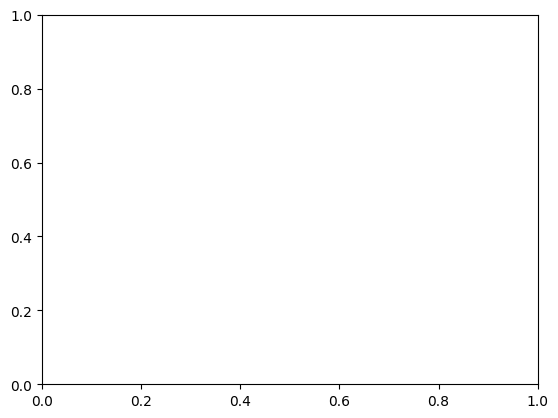

: 

In [ ]:
# Obtain epochs where accuracy was calculated in order to plot them
sa_train_accuracies_epochs= sorted(sa_train_accuracies)
sa_val_accuracies_epochs= sorted(sa_val_accuracies)
sa_epochs = [10*i for i in range(len(sa_train_accuracies))]

# Plot the evolution during training
plt.plot(sa_epochs, sa_train_accuracies, label='sa Train', linestyle='-', color='blue')
plt.plot(sa_epochs, sa_val_accuracies, label='sa Validation', linestyle='--', color='blue')
plt.axhline(y=sa_accuracy_test, label='sa Test', linestyle='-.', color='lightblue', alpha=0.5)
plt.suptitle('Recurrent Neural Network model Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()